In [29]:
import sys
sys.path.append("../")
sys.path.append("../src")
from tqdm import tqdm, trange
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load Models

In [3]:
from src.llama2 import Llama2
from src.nlp_base import NLP_base
from src.nlp_langchain import NLP_langchain
from src.openai import OpenAI

C:\Users\maryj\Documents\Mini5CMU\llamaparser-example\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


openai

In [4]:
%%time
openai = OpenAI(
    input_files=["../data/pdf/am-mid-year-outlook-2024.pdf"],
    verbose=False,
); openai.train()

CPU times: total: 3.64 s
Wall time: 18.8 s


llama2

In [5]:
%%time
llama2 = Llama2(
    input_files=["../data/pdf/am-mid-year-outlook-2024.pdf"],
    verbose=False,
); llama2.train()

CPU times: total: 8.25 s
Wall time: 18.5 s


nlp-base

In [6]:
%%time
nlp_base = NLP_base(
    input_files=["../data/pdf/am-mid-year-outlook-2024.pdf"],
    verbose=False,
); nlp_base.train()

CPU times: total: 6.3 s
Wall time: 13.6 s


nlp-langchain

In [7]:
%%time
nlp_langchain = NLP_langchain(
    input_files=["../data/pdf/am-mid-year-outlook-2024.pdf"],
    verbose=False,
); nlp_langchain.train()

CPU times: total: 12.8 s
Wall time: 14.6 s


# load Manual Labeled Data

In [8]:
questions = pd.read_csv("../data/testQ.csv")

In [11]:
sim_q_r, sim_a_r = [], []
iterator = questions[["Question", "Answer"]].to_records(index=False)
for q, a in tqdm(iterator):
    scores_q, scores_a = [], []
    for _ in range(10):
        response, score = openai.answer(q)
        scores_q.append(score)
        scores_a.append(cosine_similarity(
            [openai.embed_model.get_text_embedding(a)], 
            [openai.embed_model.get_text_embedding(str(response))],
        )[0][0])
    sim_q_r.append(np.mean(scores_q))
    sim_a_r.append(np.mean(scores_a))

100%|██████████| 15/15 [09:45<00:00, 39.06s/it]


In [12]:
res_openai = questions[["Question"]].copy()
res_openai["model"] = "openai"
res_openai["similarity_response_question"] = sim_q_r
res_openai["similarity_response_answer"] = sim_a_r

llama2

In [ ]:
sim_q_r, sim_a_r = [], []
iterator = questions[["Question", "Answer"]].to_records(index=False)
for q, a in tqdm(iterator):
    scores_q, scores_a = [], []
    for _ in range(10):
        response, score = llama2.answer(q)
        scores_q.append(score)
        scores_a.append(cosine_similarity(
            [llama2.embed_model._embed(a)], 
            [llama2.embed_model._embed(str(response))],
        )[0][0])
    sim_q_r.append(np.mean(scores_q))
    sim_a_r.append(np.mean(scores_a))

 13%|█▎        | 2/15 [20:18<2:15:57, 627.54s/it]

In [36]:
res_llama2 = questions[["Question"]].copy()
res_llama2["model"] = "llama2"
res_llama2["similarity_response_question"] = sim_q_r
res_llama2["similarity_response_answer"] = sim_a_r

nlp

In [14]:
sim_q_r, sim_a_r = [], []
iterator = questions[["Question", "Answer"]].to_records(index=False)
for q, a in tqdm(iterator):
    scores_q, scores_a = [], []
    for _ in range(10):
        response, score = nlp_base.answer(q)
        scores_q.append(score)
        scores_a.append(cosine_similarity(
            [nlp_base.embed_model._embed(a)], 
            [nlp_base.embed_model._embed(str(response))],
        )[0][0])
    sim_q_r.append(np.mean(scores_q))
    sim_a_r.append(np.mean(scores_a))

100%|██████████| 15/15 [00:50<00:00,  3.34s/it]


In [15]:
res_nlp_base = questions[["Question"]].copy()
res_nlp_base["model"] = "nlp_base"
res_nlp_base["similarity_response_question"] = sim_q_r
res_nlp_base["similarity_response_answer"] = sim_a_r

nlp langchain

In [16]:

sim_q_r, sim_a_r = [], []
iterator = questions[["Question", "Answer"]].to_records(index=False)
for q, a in tqdm(iterator):
    scores_q, scores_a = [], []
    for _ in range(10):
        response, score = nlp_langchain.answer(q)
        scores_q.append(score)
        scores_a.append(cosine_similarity(
            [nlp_langchain.embed_model._embed(a)], 
            [nlp_langchain.embed_model._embed(str(response))],
        )[0][0])
    sim_q_r.append(np.mean(scores_q))
    sim_a_r.append(np.mean(scores_a))

100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


In [17]:
res_nlp_langchain = questions[["Question"]].copy()
res_nlp_langchain["model"] = "nlp_langchain"
res_nlp_langchain["similarity_response_question"] = sim_q_r
res_nlp_langchain["similarity_response_answer"] = sim_a_r

merge and save results

In [20]:
# fix because I couldn't run llama2
res_llama2 =  pd.read_csv("./test_results.csv")
res_llama2 = res_llama2[res_llama2["model"] == "llama2"]

In [22]:
res = pd.concat([res_openai,res_llama2, res_nlp_base,res_nlp_langchain]).reset_index()
res.sort_values(["index", "model"], inplace=True, ignore_index=True)
res.drop("index", axis=1, inplace=True)
res.to_csv("./test_results.csv", index=False)

Interpretation of Columns
- `similarity_response_answer`: cosine similarity between response and manually labeled answer
- `similarity_response_question`: cosine similarity between response and input question

In [23]:
res

,Question,model,similarity_response_question,similarity_response_answer
0,How much has Norway's policy rate changed over...,llama2,0.860554,0.607631
1,How much has Norway's policy rate changed over...,nlp_base,0.682312,0.595814
2,How much has Norway's policy rate changed over...,nlp_langchain,0.667153,0.587528
3,How much has Norway's policy rate changed over...,openai,0.907887,0.744942
4,Is the shift to higher interest rates posing c...,nlp_base,0.754041,0.860071
5,Is the shift to higher interest rates posing c...,nlp_langchain,0.862293,0.923983
6,Is the shift to higher interest rates posing c...,openai,0.942232,0.884401
7,Is the shift to higher interest rates posing c...,llama2,0.880874,0.899823
8,Can small caps finally outperform?,nlp_base,0.668756,0.796996
9,Can small caps finally outperform?,nlp_langchain,0.987049,0.932814


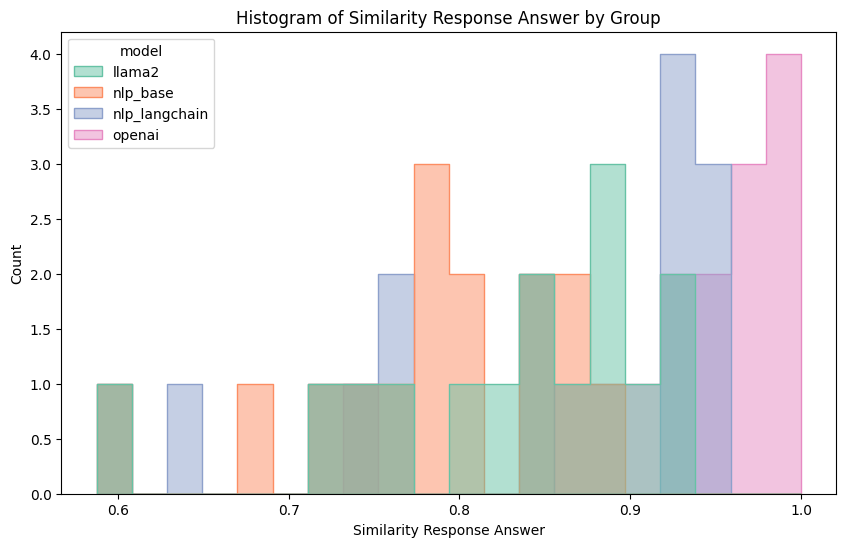

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(data=res, x='similarity_response_answer', hue='model', element='step', palette='Set2', bins=20, alpha = 0.5)

plt.title('Histogram of Similarity Response Answer by Group')
plt.xlabel('Similarity Response Answer')
plt.ylabel('Count')
plt.show()

# Responses

Questions

In [57]:
q,a = questions.loc[1,['Question','Answer']]
display(q,a)

'Is the shift to higher interest rates posing challenges to bond issuers?'

'As we near the one-year mark since the Fed funds rate peaked, our analysis suggests the core financial health of the median US investmentgrade company remains robust. Interest coverage ratios, despite a downward trend, are still near or just below historical averages. Sustained economic and earnings growth may enable resilient companies to adjust to a higher rate environment. Higher rates may also encourage a more conservative approach to capital management among corporates, which could bolster credit metrics. While the shift to higher interest rates appears generally manageable, it does pose challenges for some. We believe navigating the new landscape of higher rates and structural shifts demand an active, fundamental approach to bond selection.'

In [58]:
%%time
response, score = openai.answer(q)
print(response)

The shift to higher interest rates appears generally manageable, but it does pose challenges for some bond issuers.


In [59]:
%%time
response, score = llama2.answer(q)
print(response)

Based on the provided context, the shift to higher interest rates is likely to pose challenges to some bond issuers, but not necessarily all. The Goldman Sachs Asset Management report highlights that while the core financial health of the median US investment-grade company remains robust, interest coverage ratios are downward trending and may be affected by higher interest rates. However, the report also suggests that sustained economic and earnings growth may enable resilient companies to adjust to a higher rate environment.

Therefore, the answer to the query is: Yes, the shift to higher interest rates poses challenges to some bond issuers, but not all, as some companies may be able to adapt to the new interest rate environment.


In [60]:
%%time
response, score = nlp_base.answer(q)
print(response)

# MACROECONOMY: A LONGER PATH TO NORMALIZATION

# Three Key Questions

# 1. Is the shift to higher interest rates posing challenges to bond issuers?

Our View: As we near the one-year mark since the Fed funds rate peaked, our analysis suggests the core financial health of the median US investment-grade company remains robust. Interest coverage ratios, despite a downward trend, are still near or just below historical averages. Sustained economic and earnings growth may enable resilient companies to adjust to a higher rate environment. Higher rates may also encourage a more conservative approach to capital management among corporates, which could bolster credit metrics. While the shift to higher interest rates appears generally manageable, it does pose challenges for some. We believe navigating the new landscape of higher rates and structural shifts demand an active, fundamental approach to bond selection.

# 2. Can small caps finally outperform?

Our View: We think small caps are a coil

In [61]:
%%time
response, score = nlp_langchain.answer(q)
print(response)

# MACROECONOMY: A LONGER PATH TO NORMALIZATION

# Three Key Questions

# 1. Is the shift to higher interest rates posing challenges to bond issuers?



Our View: As we near the one-year mark since the Fed funds rate peaked, our analysis suggests the core financial health of the median US investment-grade company remains robust. Interest coverage ratios, despite a downward trend, are still near or just below historical averages. Sustained economic and earnings growth may enable resilient companies to adjust to a higher rate environment. Higher rates may also encourage a more conservative approach to capital management among corporates, which could bolster credit metrics. While the shift to higher interest rates appears generally manageable, it does pose challenges for some. We believe navigating the new landscape of higher rates and structural shifts demand an active, fundamental approach to bond selection.

# 2. Can small caps finally outperform?
CPU times: total: 46.9 ms
Wall time: 39

Question 2

In [62]:
q,a = questions.loc[4,['Question','Answer']]
display(q,a)

"What is the key takeaway of Goldman's mid-year outlook 2024?"

'1. Macroeconomy: A Longer Path to Normalization; 2. Geopolitics and Elections: Roadmaps for Resilience; 3. Tailwinds and Headwinds: Investing in Megatrends'

In [63]:
%%time
response, score = openai.answer(q)
print(response)

The key takeaway of Goldman's mid-year outlook 2024 is the importance of active and dynamic investment strategies in response to evolving macroeconomic conditions, geopolitical risks, and the acceleration of secular megatrends shaping economies and industries.
CPU times: total: 31.2 ms
Wall time: 2.24 s


In [64]:
%%time
response, score = llama2.answer(q)
print(response)

The key takeaway of Goldman Sachs' Mid-Year Outlook 2024 is that the path to normalization in the macroeconomy is likely to be longer than previously anticipated.
CPU times: total: 203 ms
Wall time: 1min 19s


In [65]:
%%time
response, score = nlp_base.answer(q)
print(response)

# Asset Management

# MID-YEAR OUTLOOK 2024

# KEY THEMES

# Macroeconomy:

A Longer Path to Normalization

# Geopolitics and Elections:

Roadmaps for Resilience

# Tailwinds and Headwinds:

Investing in Megatrends

This financial promotion is provided by Goldman Sachs Asset Management B.V.
CPU times: total: 46.9 ms
Wall time: 24.6 ms


In [66]:
%%time
response, score = nlp_langchain.answer(q)
print(response)

Goldman Sachs Asset Management

Asset Management Outlook 2024 | 11

# TAILWINDS AND HEADWINDS:

# INVESTING IN MEGATRENDS



Beyond the near-term path of inflation, rates, and election results, we remain focused on longer-term paradigm shifts, including five key structural forces: decarbonization, digitization, deglobalization, destabilization in geopolitics, and demographic aging. Active investment strategies, a focus on diversification and risk management may become increasingly important to help navigate these contours and deliver alpha. Investors who stay in their silos and focus on a single theme may miss out on opportunities and underestimate risks.
CPU times: total: 78.1 ms
Wall time: 28.5 ms
